In [94]:
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
from biotite.sequence import ProteinSequence
from biotite.sequence import find_subsequence
import numpy as np
import subprocess

In [101]:
helix1_group_ids = [0,0,0,1,1,1,2,2,2,2,3,3,3,3,3,3,4,4,4,4,5,5,5,6,6,6,6,6,6]
helix2_group_ids = np.abs(np.array([0,0,0,0,1,1,1,1,2,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,8])-8)

In [ ]:
def get_subsequence_indices(model, chainid, subsequence):
    chainid = np.where(struc.get_chains(model) == chainid)[0][0]

    seqs, seq_starts = struc.to_sequence(model)
    sequence = seqs[chainid]
    chain_start = seq_starts[chainid]
    res_starts = struc.get_residue_starts(model, add_exclusive_stop=True)
    res_starts = res_starts[res_starts>=chain_start]
    
    sub_start = find_subsequence(sequence, subsequence)
    
    if len(sub_start)>1:
        raise ValueError("Multiple subsequence detected.")
    
    sub_start = sub_start[0]
    sub_end = sub_start + len(subsequence)
    
    return res_starts[sub_start], res_starts[sub_end]

def get_cdr_sequence(sequence):
    command = ["bash", "/workspaces/tcr_structure_embedding/structure_feature/sequence/alignment/run_anarci.sh", 
            "-i", str(sequence), 
            "-s", "a"]
    command.append("--assign_germline")
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    lines = result.stdout.strip().split("#")
    alignment = lines[-1]
    alignment = alignment.strip().split("\n")[1:]
    alignment = [a.strip().split() for a in alignment if a.strip() != '//']
    if len(alignment) == 0:
        return None
    
    chain_type = np.unique([a[0] for a in alignment if (len(a)==3)])
    if len(chain_type) != 1:
        raise TypeError(f"{len(chain_type)} chains detected")
    
    cdr1 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 25) and (int(a[1]) <= 42) and (a[2].isalpha())]
    cdr2 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 58) and (int(a[1]) <= 77) and (a[2].isalpha())]
    cdr3 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 107) and (int(a[1]) <= 138) and (a[2].isalpha())]
    return chain_type[0], ''.join(cdr1), ''.join(cdr2), ''.join(cdr3)


def helix_cdr_dist(helix, cdr):
    helix_ca = helix[helix.atom_name == "CA"]
    cdr_ca   = cdr[cdr.atom_name == "CA"]
    # (n_helix, n_cdr) distances
    D = np.vstack([struc.distance(h_ca, cdr_ca) for h_ca in helix_ca])
    helix_resids = helix_ca.res_id.copy()
    cdr_resids   = cdr_ca.res_id.copy()
    return D, helix_resids, cdr_resids


In [166]:
v_out = dict()

for tcr in ['tcr14','tcr420','tcr520',"tcr363", "tcr374", "tcr462"]:

    pdb_file = pdb.PDBFile.read(
        f"/workspaces/tcr_structure_embedding/data/killing_assay/tcrmodel2_out/{tcr}/ranked_0.pdb"
    )
    obj = pdb_file.get_structure()[0]
    out = dict()

    chain_ids = struc.get_chains(obj)
    seqs, _ = struc.to_sequence(obj)
    sequences = {c: s for c, s in zip(chain_ids, seqs)}
    out['chainid_to_seq'] = sequences
    out['chain_id'] = dict()

    # --- Identify TRA / TRB / MHC / peptide ---
    for chainid, seq in sequences.items():
        aligned = get_cdr_sequence(str(seq))
        if aligned is not None:
            chaintype, cdr1, cdr2, cdr3 = aligned
            if chaintype == 'A':
                out['chain_id']['tra'] = chainid
                out['cdr_a'] = {
                    'cdr1': ProteinSequence(cdr1),
                    'cdr2': ProteinSequence(cdr2),
                    'cdr3': ProteinSequence(cdr3),
                }
            elif chaintype == 'B':
                out['chain_id']['trb'] = chainid
                out['cdr_b'] = {
                    'cdr1': ProteinSequence(cdr1),
                    'cdr2': ProteinSequence(cdr2),
                    'cdr3': ProteinSequence(cdr3),
                }
        else:
            if len(seq) > 50:
                out['chain_id']['mhca'] = chainid
                sse = struc.annotate_sse(obj[obj.chain_id == chainid])
                arr = np.where(sse == 'a')[0]
                idx_split = np.argmax(np.diff(arr))
                out['mhc'] = dict()
                out['mhc']['helix1'] = seq[arr[0]:arr[idx_split]+1]
                out['mhc']['helix2'] = seq[arr[idx_split+1]:arr[-1]+1]
            else:
                out['chain_id']['pep'] = chainid

    # --- Extract helices by subsequence ---
    mhc_chain = out['chain_id']['mhca']
    pep_chain = out['chain_id']['pep']

    helix1_start, helix1_end = get_subsequence_indices(obj, mhc_chain, out['mhc']['helix1'])
    helix2_start, helix2_end = get_subsequence_indices(obj, mhc_chain, out['mhc']['helix2'])

    helix1 = obj[helix1_start:helix1_end+1]
    helix2 = obj[helix2_start:helix2_end+1]
    peptide = obj[obj.chain_id == pep_chain]

    helix1_res_ids = np.unique(helix1.res_id)
    helix2_res_ids = np.unique(helix2.res_id)
    pep_ca = peptide[peptide.atom_name == "CA"]
    pep_res_ids = pep_ca.res_id  # same length as cdr_*_p_mat first axis

    mhc_atoms = obj[obj.chain_id == mhc_chain]

    # --- SSE on MHC, core COM from beta-sheet ---
    sse_mhc = struc.annotate_sse(mhc_atoms)   # 'a' = helix, 'b' = beta, etc.
    res_starts = struc.get_residue_starts(mhc_atoms, add_exclusive_stop=True)
    atom_counts = np.diff(res_starts)
    sse_atom = np.repeat(sse_mhc, atom_counts)

    beta_mask = (sse_atom == 'b')
    beta_atoms = mhc_atoms[beta_mask]
    core_com = np.mean(beta_atoms.coord, axis=0)

    # --- Extract CDR atoms ---
    tra_chain = out['chain_id']['tra']
    trb_chain = out['chain_id']['trb']

    cdr1a_start, cdr1a_end = get_subsequence_indices(obj, tra_chain, out['cdr_a']['cdr1'])
    cdr2a_start, cdr2a_end = get_subsequence_indices(obj, tra_chain, out['cdr_a']['cdr2'])
    cdr3a_start, cdr3a_end = get_subsequence_indices(obj, tra_chain, out['cdr_a']['cdr3'])

    cdr1b_start, cdr1b_end = get_subsequence_indices(obj, trb_chain, out['cdr_b']['cdr1'])
    cdr2b_start, cdr2b_end = get_subsequence_indices(obj, trb_chain, out['cdr_b']['cdr2'])
    cdr3b_start, cdr3b_end = get_subsequence_indices(obj, trb_chain, out['cdr_b']['cdr3'])

    cdr1a = obj[cdr1a_start:cdr1a_end+1]
    cdr2a = obj[cdr2a_start:cdr2a_end+1]
    cdr3a = obj[cdr3a_start:cdr3a_end+1]

    cdr1b = obj[cdr1b_start:cdr1b_end+1]
    cdr2b = obj[cdr2b_start:cdr2b_end+1]
    cdr3b = obj[cdr3b_start:cdr3b_end+1]

    # --- Helix–CDR distance matrices ---
    cdr_a1_1_mat, h1_resids, cdr1a_resids = helix_cdr_dist(helix1, cdr1a)
    cdr_a2_1_mat, _,          cdr2a_resids = helix_cdr_dist(helix1, cdr2a)
    cdr_a3_1_mat, _,          cdr3a_resids = helix_cdr_dist(helix1, cdr3a)
    cdr_b1_1_mat, _,          cdr1b_resids = helix_cdr_dist(helix1, cdr1b)
    cdr_b2_1_mat, _,          cdr2b_resids = helix_cdr_dist(helix1, cdr2b)
    cdr_b3_1_mat, _,          cdr3b_resids = helix_cdr_dist(helix1, cdr3b)

    cdr_a1_2_mat, h2_resids, cdr1a_resids2 = helix_cdr_dist(helix2, cdr1a)
    cdr_a2_2_mat, _,         cdr2a_resids2 = helix_cdr_dist(helix2, cdr2a)
    cdr_a3_2_mat, _,         cdr3a_resids2 = helix_cdr_dist(helix2, cdr3a)
    cdr_b1_2_mat, _,         cdr1b_resids2 = helix_cdr_dist(helix2, cdr1b)
    cdr_b2_2_mat, _,         cdr2b_resids2 = helix_cdr_dist(helix2, cdr2b)
    cdr_b3_2_mat, _,         cdr3b_resids2 = helix_cdr_dist(helix2, cdr3b)
    
    cdr_a1_p_mat, h2_resids, cdr1a_resids2 = helix_cdr_dist(peptide, cdr1a)
    cdr_a2_p_mat, _,         cdr2a_resids2 = helix_cdr_dist(peptide, cdr2a)
    cdr_a3_p_mat, _,         cdr3a_resids2 = helix_cdr_dist(peptide, cdr3a)
    cdr_b1_p_mat, _,         cdr1b_resids2 = helix_cdr_dist(peptide, cdr1b)
    cdr_b2_p_mat, _,         cdr2b_resids2 = helix_cdr_dist(peptide, cdr2b)
    cdr_b3_p_mat, _,         cdr3b_resids2 = helix_cdr_dist(peptide, cdr3b)

    # --- Classify helix faces (top vs bottom etc.) ---
    # helix1_ca = helix1[helix1.atom_name == "CA"]
    # helix2_ca = helix2[helix2.atom_name == "CA"]

    # helix1_group_ids = classify_helix_face(helix1_ca.coord, core_com)
    # helix2_group_ids = classify_helix_face(helix2_ca.coord, core_com)

    # helix1_group_ids = np.asarray(helix1_group_ids)
    # helix2_group_ids = np.asarray(helix2_group_ids)

    # --- Collect flattened distances per helix face group ---
    v = dict()
    v['helix1'] = dict()
    v['helix2'] = dict()

    # Helix 1
    for group in np.unique(helix1_group_ids):
        mask = (helix1_group_ids == group)
        v['helix1'][group] = dict(
            a1_1 = cdr_a1_1_mat[mask, :].ravel(),
            a2_1 = cdr_a2_1_mat[mask, :].ravel(),
            a3_1 = cdr_a3_1_mat[mask, :].ravel(),
            b1_1 = cdr_b1_1_mat[mask, :].ravel(),
            b2_1 = cdr_b2_1_mat[mask, :].ravel(),
            b3_1 = cdr_b3_1_mat[mask, :].ravel(),
        )

    # Helix 2
    for group in np.unique(helix2_group_ids):
        mask = (helix2_group_ids == group)
        v['helix2'][group] = dict(
            a1_2 = cdr_a1_2_mat[mask, :].ravel(),
            a2_2 = cdr_a2_2_mat[mask, :].ravel(),
            a3_2 = cdr_a3_2_mat[mask, :].ravel(),
            b1_2 = cdr_b1_2_mat[mask, :].ravel(),
            b2_2 = cdr_b2_2_mat[mask, :].ravel(),
            b3_2 = cdr_b3_2_mat[mask, :].ravel(),
        )

    # Peptide: group = each peptide residue
    v['peptide'] = dict()
    pep_ca = peptide[peptide.atom_name == "CA"]
    pep_res_ids = pep_ca.res_id

    for i, res_id in enumerate(pep_res_ids):
        group = int(res_id)
        v['peptide'][group] = dict(
            a1_p = cdr_a1_p_mat[i, :].ravel(),
            a2_p = cdr_a2_p_mat[i, :].ravel(),
            a3_p = cdr_a3_p_mat[i, :].ravel(),
            b1_p = cdr_b1_p_mat[i, :].ravel(),
            b2_p = cdr_b2_p_mat[i, :].ravel(),
            b3_p = cdr_b3_p_mat[i, :].ravel(),
        )

    v_out[tcr] = v


## Option A – Treat every distance as a replicate

Pool all distances for a given (helix, group, region) and compare the two distributions (cyto vs non) with a non-parametric test (Mann–Whitney).

Distances within the same TCR aren’t independent (pseudoreplication).

In [167]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

no_tcrs = {"tcr14", "tcr420", "tcr520"}
yes_tcrs = {"tcr363", "tcr374", "tcr462"}

In [168]:
results = []

for tcr, v in v_out.items():
    phenotype = "yes" if tcr in yes_tcrs else "no"

# we need to collect distances per (helix, group, region, phenotype)
dist_store = {}  # (helix, group, region, phenotype) -> list of distances

for tcr, v in v_out.items():
    phenotype = "yes" if tcr in yes_tcrs else "no"
    for helix in ["helix1", "helix2", "peptide"]:
        for group, region_dict in v[helix].items():
            for region_name, dists in region_dict.items():
                key = (helix, group, region_name, phenotype)
                arr = np.asarray(dists)
                arr = arr[np.isfinite(arr)]
                if arr.size == 0:
                    continue
                dist_store.setdefault(key, []).append(arr)

# concatenate all distance arrays within each key
for key in list(dist_store.keys()):
    helix, group, region_name, phenotype = key
    dist_store[key] = np.concatenate(dist_store[key])

# Now run Mann–Whitney per (helix, group, region_name)
tests = []
for helix in ["helix1", "helix2", "peptide"]:
    # find all groups for this helix
    all_groups = set(g for (h, g, r, p) in dist_store.keys() if h == helix)
    for group in all_groups:
        region_names = set(r for (h, g, r, p) in dist_store.keys()
                           if h == helix and g == group)
        for region_name in region_names:
            cy_key  = (helix, group, region_name, "yes")
            ncy_key = (helix, group, region_name, "no")
            if cy_key not in dist_store or ncy_key not in dist_store:
                continue
            cy_vals  = dist_store[cy_key]
            ncy_vals = dist_store[ncy_key]

            if (len(cy_vals) < 5) or (len(ncy_vals) < 5):
                # too few distances, skip or still test but mark as low N
                continue

            stat, p = mannwhitneyu(cy_vals, ncy_vals, alternative="two-sided")
            tests.append({
                "helix": helix,
                "group": group,
                "region": region_name,
                "n_cyto_dists": len(cy_vals),
                "n_noncyto_dists": len(ncy_vals),
                "u_stat": stat,
                "p_raw": p,
            })

results_df = pd.DataFrame(tests)

# FDR correction over all tests
if not results_df.empty:
    reject, p_adj, _, _ = multipletests(results_df["p_raw"], method="fdr_bh")
    results_df["p_adj"] = p_adj
    results_df["signif"] = reject

results_df.sort_values("p_adj", inplace=True)
print(results_df)


       helix  group region  n_cyto_dists  n_noncyto_dists   u_stat  \
19    helix1      3   b3_1           204              216  30519.0   
39    helix1      6   a3_1           246              210  17131.0   
78    helix2      6   a2_2           185              180  22676.0   
41    helix1      6   b2_1           270              282  27669.0   
90    helix2      8   a2_2           148              144  14630.0   
..       ...    ...    ...           ...              ...      ...   
124  peptide      5   a1_p            30               33    484.0   
81    helix2      6   b3_2           170              180  15421.0   
108  peptide      3   b2_p            45               47   1071.0   
98   peptide      1   a3_p            41               35    727.0   
85    helix2      7   a1_2           120              132   7873.0   

            p_raw         p_adj  signif  
19   8.760272e-12  1.314041e-09    True  
39   5.591259e-10  4.193444e-08    True  
78   2.246539e-09  1.123269e-07  

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# if your df is called result1
df = results_df.copy()
df["region_slim"] = df["region"].str[:2]

# Make a label like "helix1_g0" for rows
df["helix_group"] = df["helix"] + "_g" + df["group"].astype(str)

# Compute -log10(p_adj) (clip at some max to avoid crazy values)
df["neglog10_p"] = -np.log10(df["p_adj"].clip(lower=1e-10))

# Pivot: rows = helix_group, cols = region
heat = df.pivot(index="helix_group", columns="region_slim", values="neglog10_p")
heat

region_slim,a1,a2,a3,b1,b2,b3
helix_group,,,,,,
helix1_g0,0.769329,1.972803,0.993233,0.971456,2.441952,2.122585
helix1_g1,1.441052,1.593393,0.170419,1.048992,2.234934,2.451283
helix1_g2,2.417500,1.184384,0.486881,1.470823,1.874524,4.139325
helix1_g3,4.197514,0.402094,4.006240,3.069733,0.402094,8.881391
helix1_g4,2.866455,0.314988,4.902924,2.478524,0.905374,5.636508
helix1_g5,1.884101,0.971456,4.199856,2.008237,2.062637,3.586787
helix1_g6,2.306694,5.006531,7.377429,2.265153,6.069142,3.680675
helix2_g0,2.439110,0.562094,0.597348,0.700175,2.025720,1.594650
helix2_g1,2.791754,0.193084,0.315149,0.299896,0.790184,0.839268


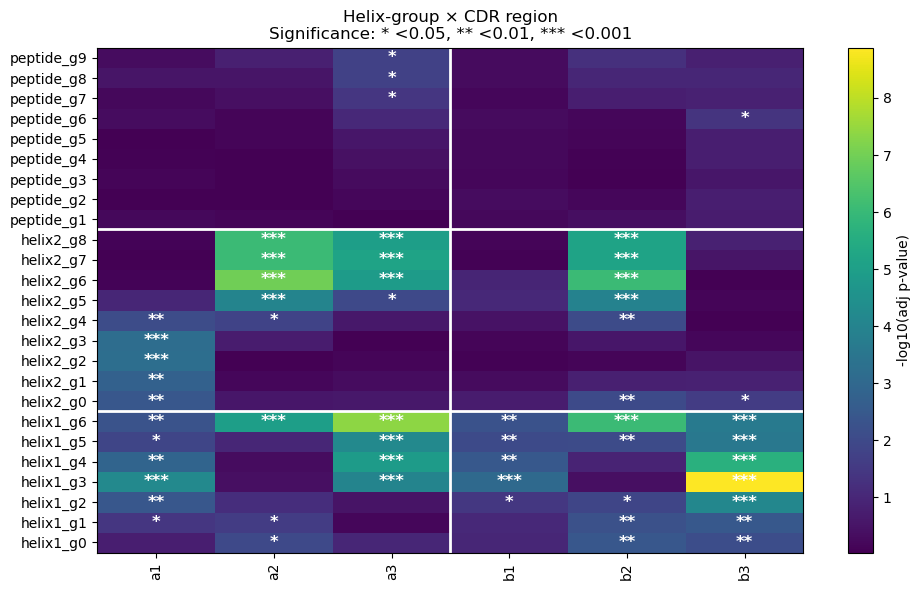

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heat.values, aspect="auto", origin="lower")

ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)
ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=90)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("-log10(adj p-value)")

# ---- Significance text: *, **, *** ----

def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

for _, row in df.iterrows():
    stars = p_to_stars(row["p_adj"])
    if stars == "":
        continue
    i = list(heat.index).index(row["helix_group"])
    j = list(heat.columns).index(row["region_slim"])
    ax.text(j, i, stars, ha="center", va="center",
            color="white", fontsize=12, fontweight="bold")

# ---- Horizontal separator: helix1 vs helix2 ----
helix1_rows = [idx for idx, name in enumerate(heat.index)
               if name.startswith("helix1")]
helix2_rows = [idx for idx, name in enumerate(heat.index)
               if name.startswith("helix2")]
if len(helix1_rows) > 0:
    last_helix1 = max(helix1_rows)
    ax.axhline(last_helix1 + 0.5, color="white", linewidth=2)
    
if len(helix2_rows) > 0:
    last_helix2 = max(helix2_rows)
    ax.axhline(last_helix2 + 0.5, color="white", linewidth=2)

# ---- Vertical separator: CDR A vs CDR B ----
a_cols = [idx for idx, c in enumerate(heat.columns) if str(c).startswith("a")]
b_cols = [idx for idx, c in enumerate(heat.columns) if str(c).startswith("b")]

if len(a_cols) > 0:
    last_a = max(a_cols)
    ax.axvline(last_a + 0.5, color="white", linewidth=2)

ax.set_title("Helix-group × CDR region\nSignificance: * <0.05, ** <0.01, *** <0.001")
plt.tight_layout()
plt.show()


In [172]:
yes_tcrs = {"tcr14", "tcr420", "tcr520"}  # cytotoxic

rows = []
for tcr, v in v_out.items():
    phenotype = "yes" if tcr in yes_tcrs else "no"
    for helix in ["helix1", "helix2", "peptide"]:
        for group, region_dict in v[helix].items():
            for region_name, dists in region_dict.items():
                arr = np.asarray(dists)
                arr = arr[np.isfinite(arr)]
                for d in arr:
                    rows.append({
                        "tcr": tcr,
                        "phenotype": phenotype,
                        "helix": helix,
                        "group": group,
                        "region": region_name,
                        "distance": d,
                    })

df_long = pd.DataFrame(rows)


row = results_df.iloc[0]
h = row["helix"]
g = row["group"]
r = row["region"]

sub = df_long[(df_long["helix"] == h) &
              (df_long["group"] == g) &
              (df_long["region"] == r)]


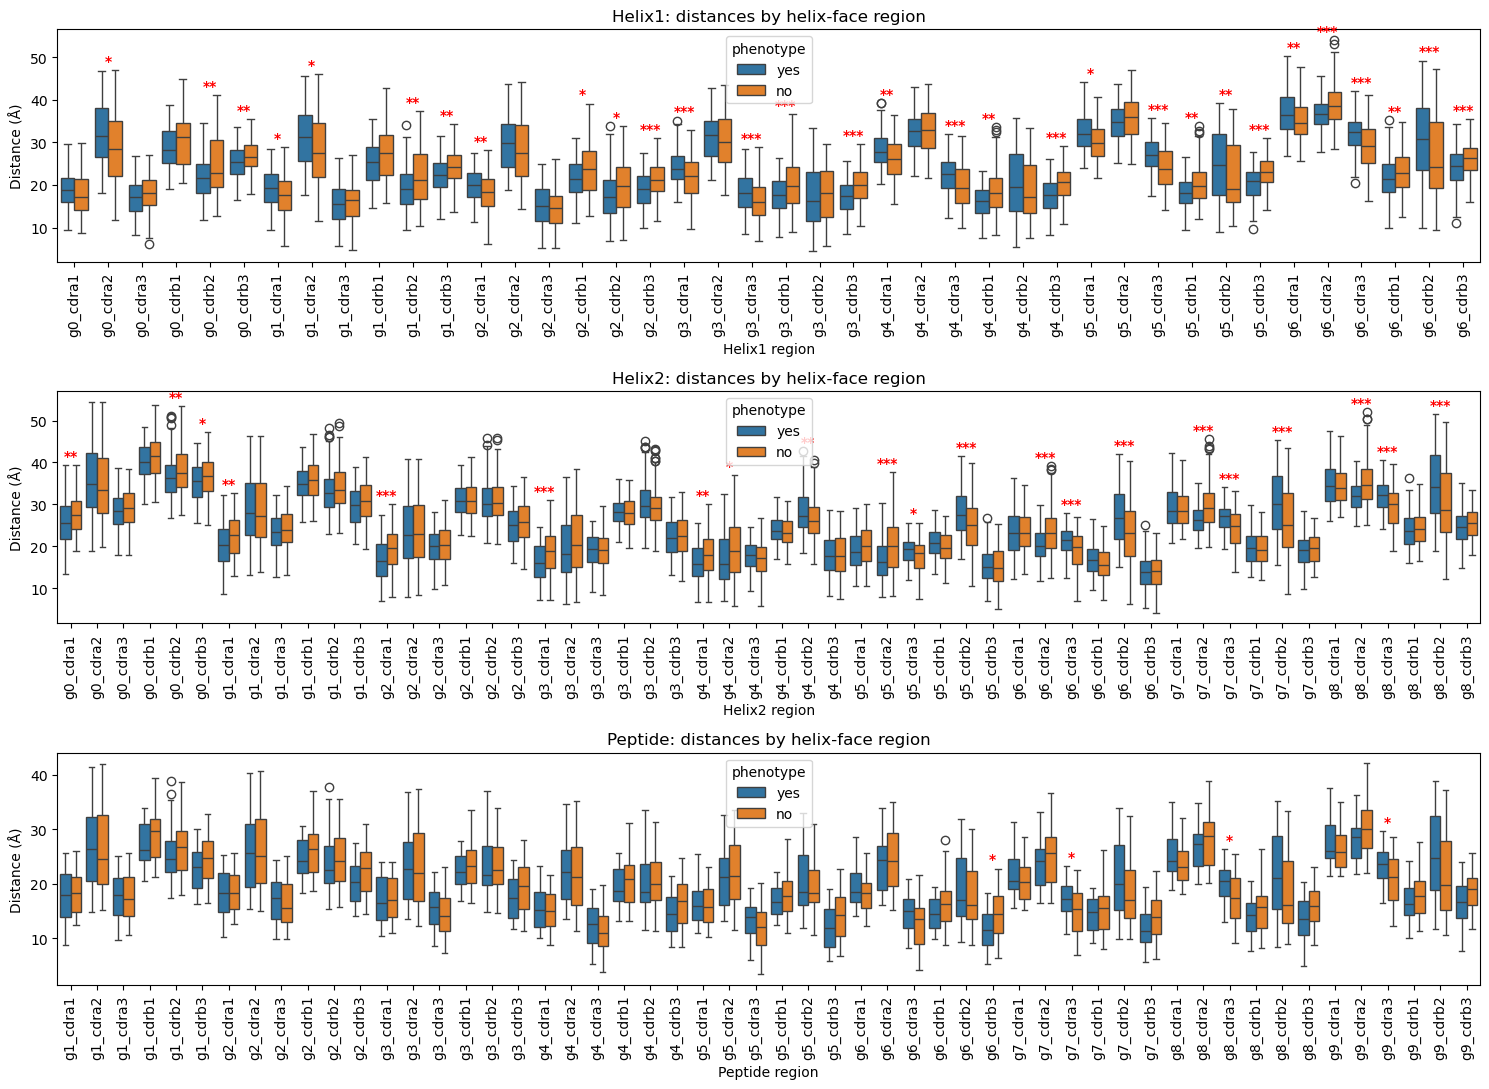

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

def format_label(row):
    helix = row["helix"]               # e.g., "helix1"
    helix_id = helix.replace("helix","")  # "1" or "2"
    helix_region = row["group"]        # integer ID of helix face

    region = row["region"]             # e.g., "a1_1"
    chain = region[0].lower()          # "A" or "B"
    cdr_num = region[1]                # "1","2","3"

    return f"g{helix_region}_cdr{chain}{cdr_num}"

# Make a dictionary for quick lookup:
# sig_map[(helix, group, region)] = True/False
sig_map = {
    (row.helix, row.group, row.region): row.signif
    for _, row in results_df.iterrows()
}

def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""
    

# Pre-index results_df for fast lookup
results_idx = results_df.set_index(["helix", "group", "region"])


def add_sig_stars(ax, df_sub, helix_name):
    """
    Add significance stars (*, **, ***) to boxplots.
    helix_name is "helix1" or "helix2".
    """
    for tick_label in ax.get_xticklabels():
        label = tick_label.get_text()  # e.g. "g0_cdra3"

        # --- PARSE LABEL ---
        group_str = label.split("_")[0]        # "g0"
        group_id  = int(group_str[1:])        # 0
        reg       = label.split("_")[1].replace("cdr","")  # "a3"

        chain = reg[0].lower()  # 'a' or 'b'
        cnum  = reg[1]          # '1','2','3'

        # Find matching region in df_sub (region like "a3_1","a3_2",...)
        possible = df_sub[
            (df_sub["helix"] == helix_name)
            & (df_sub["group"] == group_id)
            & (df_sub["region"].str.startswith(chain + cnum))
        ]
        if possible.empty:
            continue

        region_name = possible["region"].iloc[0]

        key = (helix_name, group_id, region_name)
        if key not in results_idx.index:
            continue

        p_adj = results_idx.loc[key, "p_adj"]
        stars = p_to_stars(p_adj)
        if stars == "":
            continue

        # Position to place the stars
        xpos = tick_label.get_position()[0]
        ymax = df_sub[df_sub["grp_reg"] == label]["distance"].max()

        ax.text(
            xpos,
            ymax + 0.5,    # shift above the box
            stars,
            ha="center",
            va="bottom",
            fontsize=10,
            color="red",
            fontweight="bold",
        )



sub1 = df_long[df_long["helix"] == "helix1"].copy()
sub1["grp_reg"] = sub1.apply(format_label, axis=1)

sub2 = df_long[df_long["helix"] == "helix2"].copy()
sub2["grp_reg"] = sub2.apply(format_label, axis=1)

sub3 = df_long[df_long["helix"] == "peptide"].copy()
sub3["grp_reg"] = sub3.apply(format_label, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 11))

sns.boxplot(data=sub1, x="grp_reg", y="distance", hue="phenotype", ax=ax1)
ax1.set_title("Helix1: distances by helix-face region")
ax1.set_ylabel("Distance (Å)")
ax1.set_xlabel("Helix1 region")
ax1.tick_params(axis="x", rotation=90)
add_sig_stars(ax1, sub1, "helix1")

sns.boxplot(data=sub2, x="grp_reg", y="distance", hue="phenotype", ax=ax2)
ax2.set_title("Helix2: distances by helix-face region")
ax2.set_ylabel("Distance (Å)")
ax2.set_xlabel("Helix2 region")
ax2.tick_params(axis="x", rotation=90)
add_sig_stars(ax2, sub2, "helix2")

sns.boxplot(data=sub3, x="grp_reg", y="distance", hue="phenotype", ax=ax3)
ax3.set_title("Peptide: distances by helix-face region")
ax3.set_ylabel("Distance (Å)")
ax3.set_xlabel("Peptide region")
ax3.tick_params(axis="x", rotation=90)
add_sig_stars(ax3, sub3, "peptide")

plt.tight_layout()
plt.show()


In [177]:
df_stats = results_df.copy()

# Reduce region name: "a1_1" → "a1"
df_stats["region_slim"] = df_stats["region"].str[:2]
wanted = ["a1", "a2", "a3", "b1", "b2", "b3"]
df_stats = df_stats[df_stats["region_slim"].isin(wanted)]

# Compute delta distance (median yes – median no)
# Make helix_group label
df_stats["helix_group"] = df_stats["helix"] + "_g" + df_stats["group"].astype(str)


# Add region_slim to long DF to match
df_long2 = df_long.copy()
df_long2["region_slim"] = df_long2["region"].str[:2]

# Keep only desired regions
df_long2 = df_long2[df_long2["region_slim"].isin(wanted)]

# Median (or mean) distance per helix/group/region_slim/phenotype
summary = (
    df_long2
    .groupby(["helix", "group", "region_slim", "phenotype"])["distance"]
    .median()   # <-- change to .mean() if you prefer mean
    .unstack("phenotype")
)

# Some combos may be missing "yes" or "no"; drop those safely
summary = summary.dropna(subset=["yes", "no"], how="any")

# Δ distance: cytotoxic ("yes") - noncytotoxic ("no")
summary["delta_dist"] = summary["yes"] - summary["no"]

# Turn index into columns for merging
summary = summary.reset_index()

df_stats = df_stats.merge(
    summary[["helix", "group", "region_slim", "delta_dist"]],
    on=["helix", "group", "region_slim"],
    how="left"
)
df_stats

,helix,group,region,n_cyto_dists,n_noncyto_dists,u_stat,p_raw,p_adj,signif,region_slim,helix_group,delta_dist
0,helix1,3,b3_1,204,216,30519.0,8.760272e-12,1.314041e-09,True,b3,helix1_g3,-2.708055
1,helix1,6,a3_1,246,210,17131.0,5.591259e-10,4.193444e-08,True,a3,helix1_g6,3.361874
2,helix2,6,a2_2,185,180,22676.0,2.246539e-09,1.123269e-07,True,a2,helix2_g6,-3.137930
3,helix1,6,b2_1,270,282,27669.0,2.818751e-08,8.528216e-07,True,b2,helix1_g6,6.652073
4,helix2,8,a2_2,148,144,14630.0,3.623067e-08,8.528216e-07,True,a2,helix2_g8,-2.723339
...,...,...,...,...,...,...,...,...,...,...,...,...
145,peptide,5,a1_p,30,33,484.0,8.851045e-01,9.093539e-01,False,a1,peptide_g5,0.150004
146,helix2,6,b3_2,170,180,15421.0,8.986484e-01,9.169882e-01,False,b3,helix2_g6,-0.233517
147,peptide,3,b2_p,45,47,1071.0,9.191218e-01,9.314850e-01,False,b2,peptide_g3,-0.891981
148,peptide,1,a3_p,41,35,727.0,9.252751e-01,9.314850e-01,False,a3,peptide_g1,0.602175


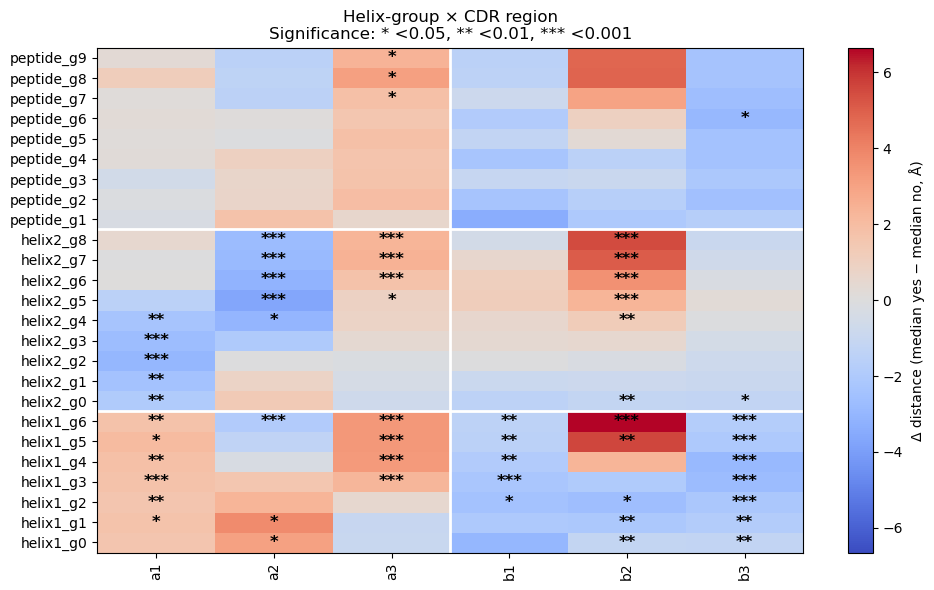

In [182]:
# Pivot: rows = helix_group, cols = region
heat = df_stats.pivot(index="helix_group", columns="region_slim", values="delta_dist")
heat = heat.reindex(columns=wanted)

from matplotlib.colors import TwoSlopeNorm
# --- Center color scale at 0 ---
vmin = np.nanmin(heat.values)
vmax = np.nanmax(heat.values)

# Make symmetric range around 0
abs_max = max(abs(vmin), abs(vmax))

norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)


fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heat.values, aspect="auto", origin="lower", cmap="coolwarm", norm=norm)

ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)
ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=90)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Δ distance (median yes − median no, Å)")

# ---- Significance text: *, **, *** ----

def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

for _, row in df_stats.dropna(subset=["delta_dist"]).iterrows():
    stars = p_to_stars(row["p_adj"])
    if stars == "":
        continue

    # Locate cell in heat
    i = list(heat.index).index(row["helix_group"])
    j = list(heat.columns).index(row["region_slim"])

    ax.text(j, i, stars,
            ha="center", va="center",
            color="black", fontsize=12, fontweight="bold")


# ---- Horizontal separator: helix1 vs helix2 ----
helix1_rows = [idx for idx, name in enumerate(heat.index)
               if name.startswith("helix1")]
helix2_rows = [idx for idx, name in enumerate(heat.index)
               if name.startswith("helix2")]
if len(helix1_rows) > 0:
    last_helix1 = max(helix1_rows)
    ax.axhline(last_helix1 + 0.5, color="white", linewidth=2)
    
if len(helix2_rows) > 0:
    last_helix2 = max(helix2_rows)
    ax.axhline(last_helix2 + 0.5, color="white", linewidth=2)

# ---- Vertical separator: CDR A vs CDR B ----
a_cols = [idx for idx, c in enumerate(heat.columns) if str(c).startswith("a")]
b_cols = [idx for idx, c in enumerate(heat.columns) if str(c).startswith("b")]

if len(a_cols) > 0:
    last_a = max(a_cols)
    ax.axvline(last_a + 0.5, color="white", linewidth=2)

ax.set_title("Helix-group × CDR region\nSignificance: * <0.05, ** <0.01, *** <0.001")
plt.tight_layout()
plt.show()


## Option B – One summary per TCR (safer statistically)

For each TCR × helix × group × region, compute a summary (mean/median/min distance).

Then compare 3 cyto vs 3 non (n is small but conceptually clean).

In [110]:
rows = []

for tcr, v in v_out.items():
    phenotype = "yes" if tcr in yes_tcrs else "no"
    for helix in ["helix1", "helix2"]:
        for group, region_dict in v[helix].items():
            for region_name, dists in region_dict.items():
                arr = np.asarray(dists)
                arr = arr[np.isfinite(arr)]
                if arr.size == 0:
                    continue
                rows.append({
                    "tcr": tcr,
                    "phenotype": phenotype,
                    "helix": helix,
                    "group": group,
                    "region": region_name,
                    "mean_dist": np.mean(arr),
                    "median_dist": np.median(arr),
                    "min_dist": np.min(arr),
                })

df = pd.DataFrame(rows)

tests2 = []
for (helix, group, region), sub in df.groupby(["helix", "group", "region"]):
    cy_vals  = sub[sub["phenotype"] == "cyto"]["mean_dist"].values
    ncy_vals = sub[sub["phenotype"] == "non"]["mean_dist"].values

    # need at least 1 per group ideally; you currently have 3 vs 3
    if (len(cy_vals) < 1) or (len(ncy_vals) < 1):
        continue

    stat, p = mannwhitneyu(cy_vals, ncy_vals, alternative="two-sided")
    tests2.append({
        "helix": helix,
        "group": group,
        "region": region,
        "n_cyto": len(cy_vals),
        "n_noncyto": len(ncy_vals),
        "u_stat": stat,
        "p_raw": p,
    })

results2 = pd.DataFrame(tests2)

if results2.empty:
    print("No valid tests were performed (results2 is empty).")
    print("Possible reasons:")
    print("- For every (helix, group, region), there were <2 cytotoxic or <2 non-cytotoxic TCRs.")
    print("- Or v_out is missing some regions for some TCRs.")
else:
    # FDR correction
    reject, p_adj, _, _ = multipletests(results2["p_raw"], method="fdr_bh")
    results2["p_adj"] = p_adj
    results2["signif"] = reject

    results2.sort_values("p_adj", inplace=True)
    print(results2)
    


No valid tests were performed (results2 is empty).
Possible reasons:
- For every (helix, group, region), there were <2 cytotoxic or <2 non-cytotoxic TCRs.
- Or v_out is missing some regions for some TCRs.


In [88]:
def classify_helix_face(structure, mhc_chain, helix_res_ids, core_com):
    """
    Returns (top_res_ids, bottom_res_ids) for helix residues.
    'Top' = side chain points away from the β-sheet core.
    """
    top_res = []
    bottom_res = []

    backbone_names = np.array(["N", "CA", "C", "O"])

    for res_id in helix_res_ids:
        res_mask = (structure.chain_id == mhc_chain) & (structure.res_id == res_id)
        res_atoms = structure[res_mask]

        if res_atoms.array_length() == 0:
            continue

        # Side-chain heavy atoms (exclude backbone)
        sc_mask = ~np.isin(res_atoms.atom_name, backbone_names)
        sc_atoms = res_atoms[sc_mask]

        # If no side-chain atoms (e.g. GLY), you can skip or use CA only
        if sc_atoms.array_length() == 0:
            # optional: treat CA as sidechain directionless and skip
            continue

        # CA coordinate
        ca_coord = res_atoms.coord[res_atoms.atom_name == "CA"][0]

        # Side-chain COM
        sc_com = np.mean(sc_atoms.coord, axis=0)

        v_sc   = sc_com - ca_coord         # sidechain direction
        v_core = core_com - ca_coord       # toward β-sheet core

        # Avoid zero-length vectors
        if np.linalg.norm(v_sc) == 0 or np.linalg.norm(v_core) == 0:
            continue

        cos_theta = np.dot(v_sc, v_core) / (np.linalg.norm(v_sc) * np.linalg.norm(v_core))

        if cos_theta < 0:
            # angle > 90°, side chain points away from core → "top"
            top_res.append(res_id)
        else:
            bottom_res.append(res_id)

    return np.array(top_res, dtype=int), np.array(bottom_res, dtype=int)


In [89]:
top_helix1_res_ids, bottom_helix1_res_ids = classify_helix_face(
    obj, "A", helix1_res_ids, core_com
)
top_helix2_res_ids, bottom_helix2_res_ids = classify_helix_face(
    obj, "A", helix2_res_ids, core_com
)